In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
current_directory = os.getcwd()
while current_directory.endswith("Notebooks"):
    os.chdir("..")
    current_directory = os.getcwd()
    print("Current working directory: ", current_directory)

Current working directory:  c:\Users\thomaswi\OneDrive - SINTEF\Drilling and well\Code\CodeForMaster


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import pickle 
from pathlib import Path

from torch.optim import Adam
from torch.utils.data import DataLoader
from torchinfo import summary
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from utils.filepaths.filepaths import FILE_PATH_FLOW_LOOP_DATA, FILE_PATH_BEST_MODELS_FEATURE_2, FILE_PATH_MODEL_RESULTS_FEATURE_2
from utils.datasets.datasets import MLPDataset
from utils.training.training import k_fold_cross_validation, k_fold_cross_validation_sklearn_models
from utils.models.models import MLP
from utils.utils.utils import test_results_confmat, define_threshold

import seaborn as sns

sns.set_theme()

In [4]:
FILE_PATH_BEST_MODELS = FILE_PATH_BEST_MODELS_FEATURE_2
BEST_MODEL_PATH = Path("Notebooks","models","nn_on_flow_loop_data_feature_2_no_regula")
DATA_PATH = FILE_PATH_MODEL_RESULTS_FEATURE_2

In [5]:
with open(FILE_PATH_FLOW_LOOP_DATA, 'r')as file:
    data = file.readlines()
    changed_data = []
    for line in data:
        changed_line = line.strip().split('\t')
        changed_data.append(changed_line)
        

In [6]:
df = pd.DataFrame(data=changed_data[1:], columns = changed_data[0])
df = df.drop(index = 0)

In [7]:
print(df.columns)
df = df[df["Cuttings conc quality"]=='1']

Index(['mean File name', 'mean StartTime', 'mean EndTime', 'mean DPT1',
       'mean DPT2', 'mean DPT3', 'mean Torque', 'mean MudDensity',
       'mean Tankweight', 'mean TempTank', 'mean SandRate', 'mean Flow',
       'mean DPT4', 'mean DPR1', 'mean DPR2', 'mean TestSectionWeight',
       'mean SetPoint', 'mean USL', 'mean StringRPM',
       'mean relBedHeightTankWeight', 'mean relBedHeightTestSectionWeight',
       'mean fricCoeff', 'std DPT1', 'std DPT2', 'std DPT3', 'std Torque',
       'std MudDensity', 'std Tankweight', 'std TempTank', 'std SandRate',
       'std Flow', 'std DPT4', 'std DPR1', 'std DPR2', 'std TestSectionWeight',
       'std SetPoint', 'std USL', 'std StringRPM',
       'std relBedHeightTankWeight', 'std relBedHeightTestSectionWeight',
       'std fricCoeff', 'drift DPT1', 'drift DPT2', 'drift DPT3',
       'drift Torque', 'drift MudDensity', 'drift Tankweight',
       'drift TempTank', 'drift SandRate', 'drift Flow', 'drift DPT4',
       'drift DPR1', 'drift DPR

In [8]:
# No flow behavior index since I am not sure if I can use that for field data
# Friction coefficient had many nan values. See what to do about this later
# Might not need it as you probably do not have it for field
print(df["Eccentricity"].unique())
dict_of_variables = {
    "Slip ratio" : df["Particle slip ratio in test section"].astype("float32"),
    "Particle bed height" : df["mean relBedHeightTestSectionWeight"].astype('float32'),
    # "Eccentricity" : df["Eccentricity"].astype("float32"),
    # "Inclination" : df["Inclination"],
    "Reynolds / Taylor" : df["Reynolds annulus (no cuttings)"].astype("float32") / df["Taylor number"].astype("float32")**2,
    # "Shields" : df["Shields number"].astype("float32"),
    # "Froude" : df["Froude number"].astype("float32"),
    # 'Reynolds by Bingham' : df["Reynolds annulus (no cuttings)"].astype("float32") * df["Bingham number"].astype("float32"),
    'Taylor by Bingham' : df["Taylor number"].astype("float32") * df["Bingham number"].astype("float32"),
    'Reynolds / Friction fac' : df["Reynolds annulus (no cuttings)"].astype("float32") /  df["Friction factor mod annulus"].astype("float32"),
    # 'Reynolds by taylor' : df["Reynolds annulus (no cuttings)"].astype("float32") / df["Taylor number"].astype("float32")
    # "Friction coef" : df["mean fricCoeff"].astype("float32"),
}
df = pd.DataFrame(dict_of_variables)
# df = df[(df.drop(columns=["Inclination"])>0).all(axis=1)]
df = df[(df>0).all(axis = 1)]

['1' '0.5']


In [9]:
# Encoding fluid categorically
fluid_mapping = {'EMSVersatec' : 1.0, 'Glydril': 0.0}
# df["Fluid name"] = df["Fluid name"].map(fluid_mapping)
# Likewise for inclination
inclination_mapping = {'90' : 2.0, '60' : 1.0, '48': 0.0}
# df["Inclination"] = df["Inclination"].map(inclination_mapping)
print(df["Slip ratio"].unique())


[0.392291  0.139438  0.264743  0.300785  0.548815  0.238455  0.303072
 0.711259  0.939416  0.353913  0.18192   0.381762  0.667095  0.351515
 0.641373  0.693481  0.312581  0.570801  0.336475  0.839277  0.237097
 0.553985  0.737844  0.38472   0.787898  0.722696  0.328141  0.652175
 0.669824  0.371048  0.81547   0.193785  0.374044  0.379493  0.317746
 0.568153  0.321209  0.570434  0.173783  0.233205  0.246302  0.349167
 0.640981  0.0821892 0.0962258 0.278417  0.482481  0.584945  0.575925
 0.915504  0.36945   0.411546  0.0652629 0.231479  0.515822  0.0432605
 0.0721444 0.264289  0.560577  0.0636316 0.432301  0.0691023 0.456334
 0.964522  0.078139  0.638568  0.0890773 0.2121    0.434177  0.0858607
 0.34384   0.883381  0.102412  0.195381  0.421603  0.0927884 0.194474
 0.372572  0.106909  0.188358  0.871206  0.104448  0.469321  0.114617
 0.358872  0.0856569 0.0977207 0.451238  0.102187  0.308066  0.0755612
 0.431419 ]


In [10]:
# Creating a value for the threshold of the slip ratio based on the relative cuttting bed height

threshold = define_threshold(df["Slip ratio"].values,rel_bed_height=df["Particle bed height"], height_threshold=0.0575)
print(threshold)

0.392291


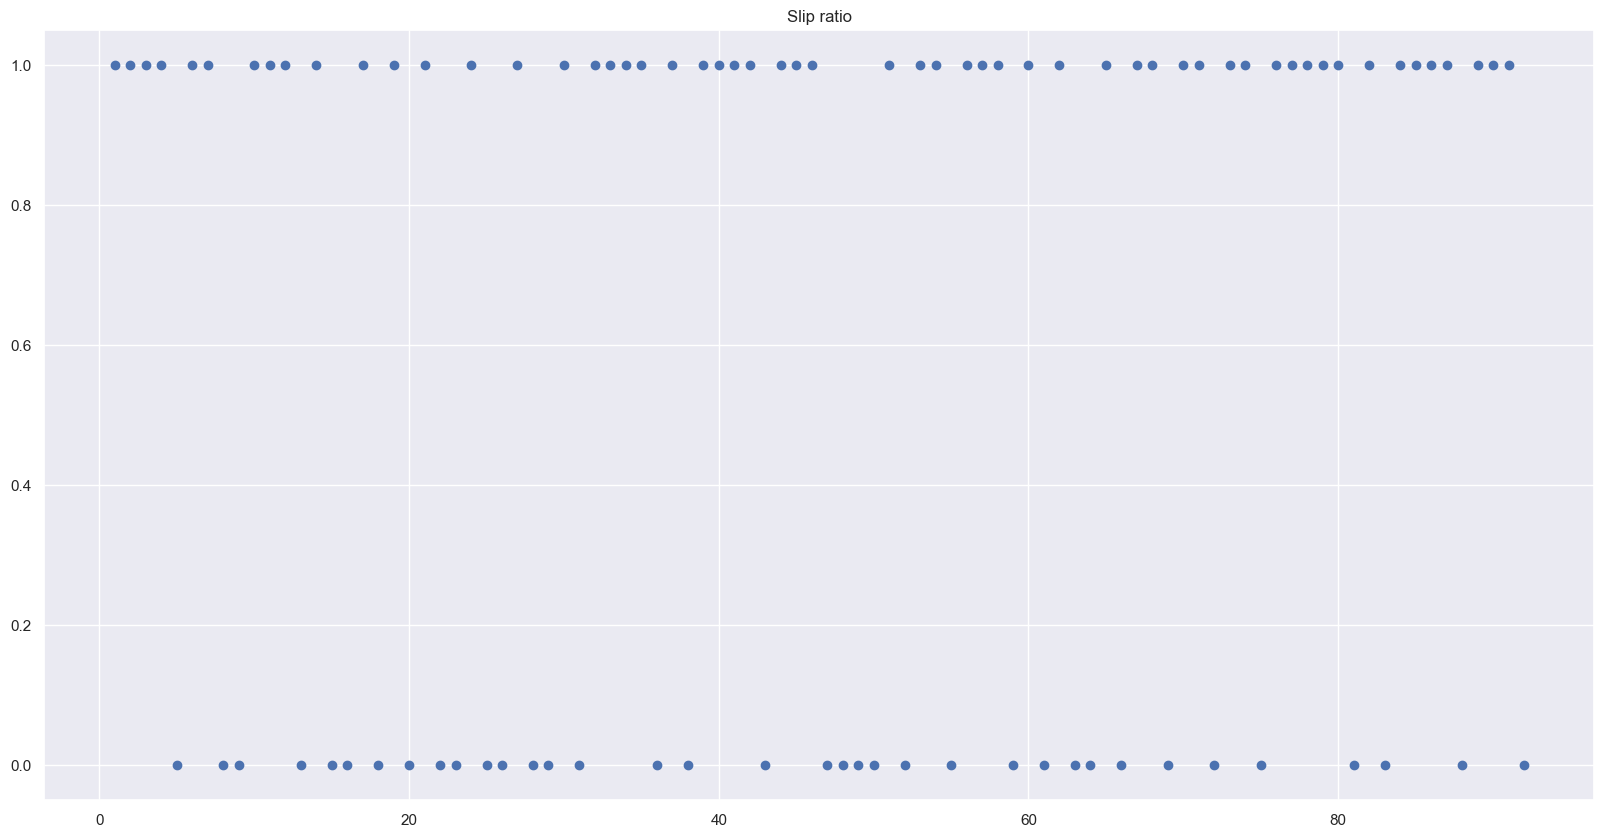

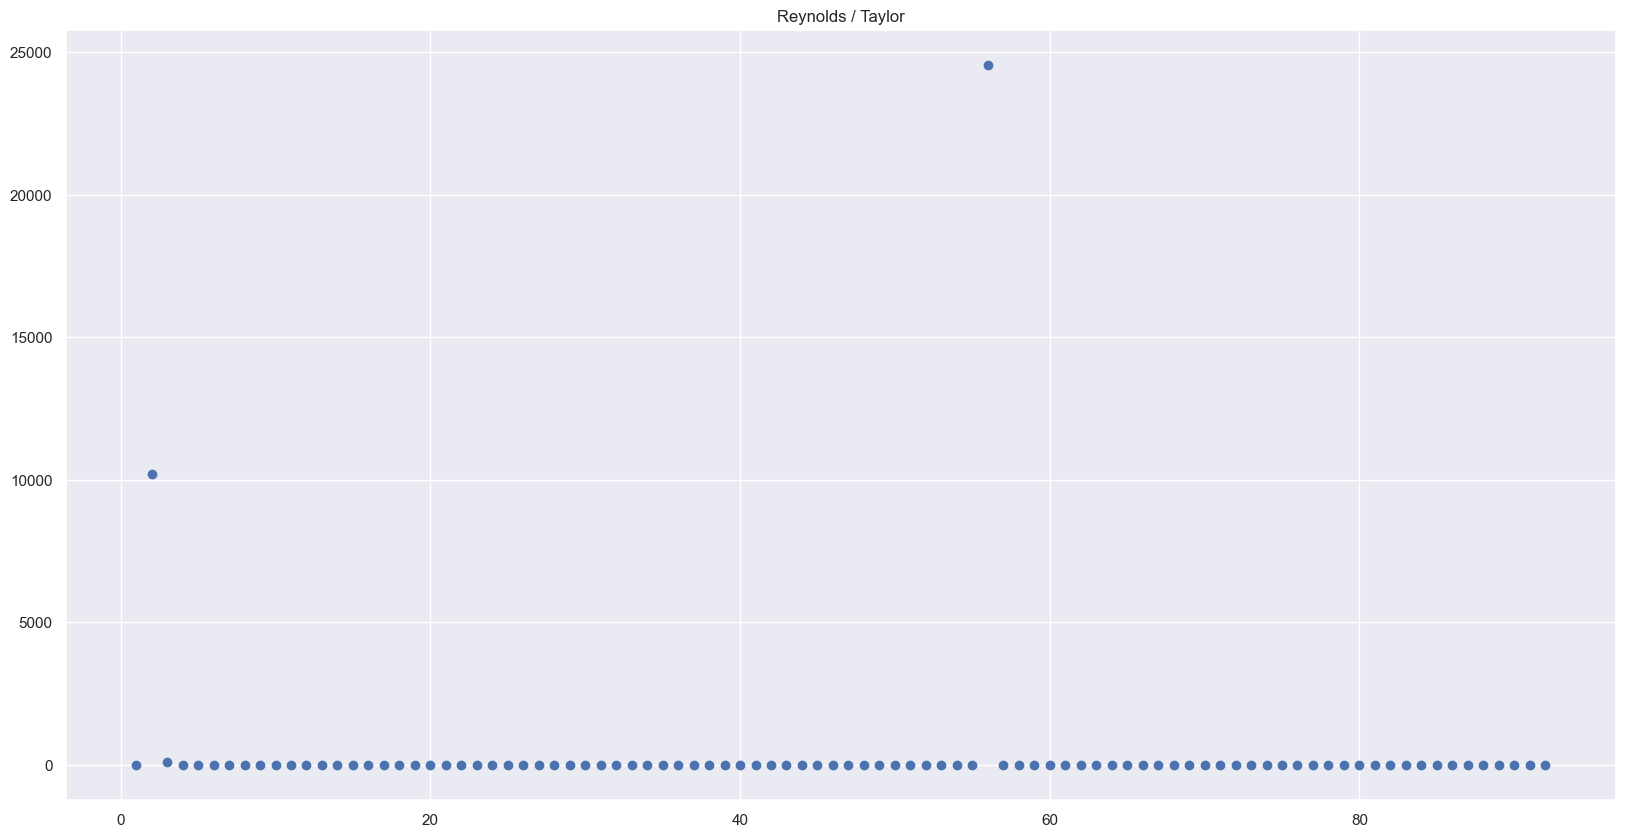

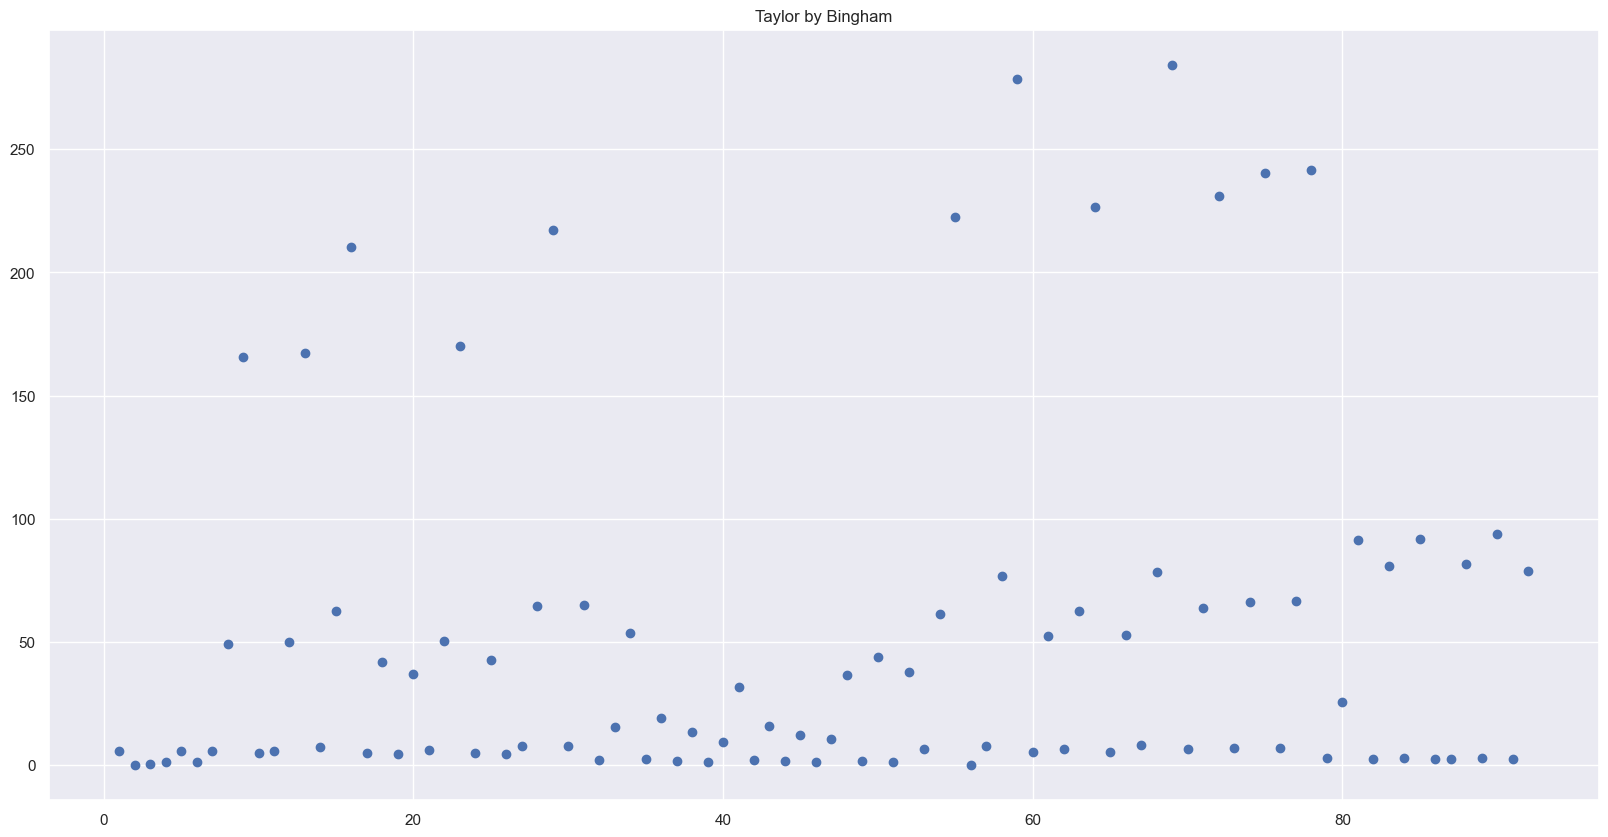

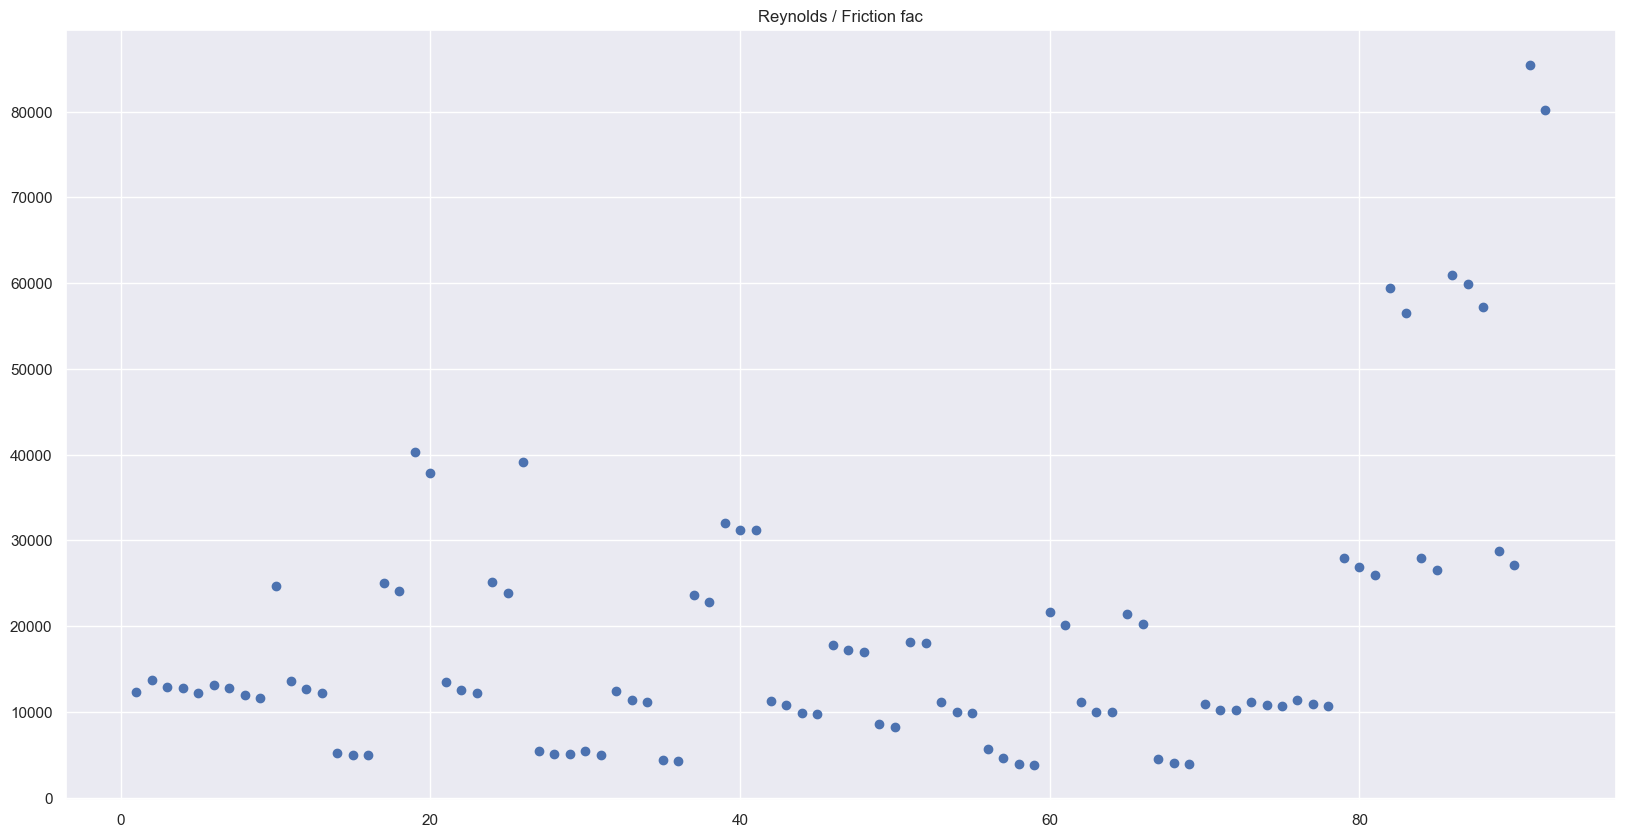

In [11]:
df["Slip ratio"] = df["Slip ratio"].apply(lambda x: 0 if x > threshold else 1)
df = df.drop(columns = "Particle bed height")
x_points = np.arange(1, len(df)+1,1)
for column in df:
    plt.figure(figsize=(20,10))
    plt.title(column)
    plt.scatter(x_points,df[column].values)
    plt.show()

In [12]:
df = df.sample(frac = 1, random_state = 42).reset_index(drop = True)

In [13]:
print(df.isna().sum())

Slip ratio                 0
Reynolds / Taylor          0
Taylor by Bingham          0
Reynolds / Friction fac    0
dtype: int64


In [14]:
param_grid_logreg = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],   # Inverse of regularization strength
    'solver': ['newton-cholesky', 'newton-cg', 'lbfgs','sag','saga'],  # Optimization algorithm
    'penalty': [None, 'l2'],  # Regularization type (Note: 'l1' is only compatible with 'liblinear' and 'saga')
    'max_iter': [100, 200],  # Number of iterations
    'tol': [1e-4, 1e-3]  # Tolerance
}

param_grid_rf = {
    'n_estimators': [50,65,80,100,115,130,150,500],
    'max_depth': [5,6,7,8,9,10,11,12,13,14],
    'min_samples_split': [2,3,4,5],                   # Minimum samples required to split a node
    'min_samples_leaf': [2,3,4,5],                     # Minimum samples required at a leaf node
    'bootstrap': [True, False],
    'criterion' : ['gini','entropy'],
    'max_features' : ['log2','sqrt']
}

param_grid_svc = { 
    'C': [1e-2, 0.1, 1.0,100,1000],
    'gamma': [1e-4, 1e-3, 1e-2,1e-1,1],
    'kernel' : ['rbf','linear','poly'],
}


param_grid_xg = {'gamma': [0,0.1,0.2,0.4,0.8,1.6,3.2,6.4,12.8,25.6,51.2,102.4, 200],
              'learning_rate': [0.01, 0.03, 0.06, 0.1, 0.15, 0.2, 0.25, 0.30, 0.4, 0.5, 0.6, 0.7],
              'max_depth': [5,6,7,8,9,10,11,12,13,14],
              'n_estimators': [50,65,80,100,115,130,150,500],
              'reg_alpha': [0,0.1,0.2,0.4,0.8,1.6,3.2,6.4,12.8,25.6,51.2,102.4,200],
              'reg_lambda': [0,0.1,0.2,0.4,0.8,1.6,3.2,6.4,12.8,25.6,51.2,102.4,200],
              'min_child_weight' : [1,2,3,4,5]}

In [15]:
n_splits = 5
k_fold_outer = KFold(n_splits = n_splits, shuffle = True, random_state = 50)
k_fold_inner = KFold(n_splits = n_splits, shuffle = True, random_state = 50)
data_k_fold_nn, best_fold_nn, avg_acc_nn = k_fold_cross_validation(df=df, split_percentage = 0.9, n_splits = n_splits,hidden_size=128, batch_size = 8, num_epochs = 120, model_path=BEST_MODEL_PATH, learning_rate = 1e-3, kfold=k_fold_outer,target_column='Slip ratio', task = 'classification', criterion=nn.BCELoss(),weight_decay=0.0, dropout = 0.0, z_score=False)


data_k_fold_xg, best_fold_xg, best_model_xg,avg_acc_xg = k_fold_cross_validation_sklearn_models(df=df,split_percentage=0.9,model=XGBClassifier,n_splits=n_splits,kfold_outer=k_fold_outer, kfold_inner=k_fold_inner, param_grid=param_grid_xg, target_column='Slip ratio', z_score=True)
data_k_fold_logreg, best_fold_logreg, best_model_logreg,avg_acc_logreg = k_fold_cross_validation_sklearn_models(df=df,split_percentage=0.9,model=LogisticRegression,n_splits=n_splits,kfold_outer=k_fold_outer, kfold_inner=k_fold_inner, param_grid=param_grid_logreg, target_column='Slip ratio', z_score = True)
data_k_fold_rf, best_fold_rf, best_model_rf,avg_acc_rf = k_fold_cross_validation_sklearn_models(df=df,split_percentage=0.9,model=RandomForestClassifier,n_splits=n_splits,kfold_outer=k_fold_outer, kfold_inner=k_fold_inner, param_grid=param_grid_rf, target_column='Slip ratio',z_score = True)
data_k_fold_svc, best_fold_svc, best_model_svc,avg_acc_svc = k_fold_cross_validation_sklearn_models(df=df,split_percentage=0.9,model=SVC,n_splits=n_splits,kfold_outer=k_fold_outer, kfold_inner=k_fold_inner, param_grid=param_grid_svc, target_column='Slip ratio', z_score = True)

Training for fold 1...
Training...
Saving best model for epoch 1 with accuracy 0.59
Saving best model for epoch 7 with accuracy 0.71
Training for fold 2...
Training...
Saving best model for epoch 1 with accuracy 0.59
Saving best model for epoch 8 with accuracy 0.65
Saving best model for epoch 10 with accuracy 0.76
Saving best model for epoch 13 with accuracy 0.82
Saving best model for epoch 31 with accuracy 0.88
Training for fold 3...
Training...
Saving best model for epoch 1 with accuracy 0.81
Training for fold 4...
Training...
Saving best model for epoch 1 with accuracy 0.69
Saving best model for epoch 16 with accuracy 0.75
Training for fold 5...
Training...
Saving best model for epoch 1 with accuracy 0.56
Saving best model for epoch 6 with accuracy 0.62
Saving best model for epoch 7 with accuracy 0.69
Training final model...
Training...
Saving best model for epoch 1 with accuracy 0.40
Saving best model for epoch 4 with accuracy 0.60
Saving best model for epoch 11 with accuracy 0.70


5it [02:12, 26.58s/it]


Best model found for fold: 1 with accuracy of 0.82 average accuracy is:  0.6926470588235294


0it [00:00, ?it/s]c:\Users\thomaswi\AppData\Local\miniconda3\envs\master_thesis\Lib\site-packages\sklearn\linear_model\_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\thomaswi\AppData\Local\miniconda3\envs\master_thesis\Lib\site-packages\sklearn\linear_model\_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\thomaswi\AppData\Local\miniconda3\envs\master_thesis\Lib\site-packages\sklearn\linear_model\_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\thomaswi\AppData\Local\miniconda3\envs\master_thesis\Lib\site-packages\sklearn\linear_model\_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\thomaswi\AppData\Local\miniconda3\envs\master_thesis\Lib\site-packages\sklearn\linear_model\_logistic.py:1208: UserWarnin

Best model found for fold: 2 with accuracy of 0.76 average accuracy is:  0.7073529411764705


5it [10:09, 121.81s/it]


Best model found for fold: 1 with accuracy of 0.82 average accuracy is:  0.6691176470588236


0it [00:00, ?it/s]c:\Users\thomaswi\AppData\Local\miniconda3\envs\master_thesis\Lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 75 is smaller than n_iter=100. Running 75 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
1it [00:02,  2.48s/it]c:\Users\thomaswi\AppData\Local\miniconda3\envs\master_thesis\Lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 75 is smaller than n_iter=100. Running 75 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
2it [00:07,  4.23s/it]c:\Users\thomaswi\AppData\Local\miniconda3\envs\master_thesis\Lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 75 is smaller than n_iter=100. Running 75 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
3it [00:11,  3.90s/it]c:\Users\thomaswi\AppData\Local\miniconda3\envs\master_thesis\Lib\site-packages\sklea

Best model found for fold: 3 with accuracy of 0.75 average accuracy is:  0.6948529411764707


In [16]:
data = {'Neural network' : data_k_fold_nn,
        'XGBoost' : data_k_fold_xg,
        'LogisticRegression' : data_k_fold_logreg,
        'Random forest' : data_k_fold_rf,
        'Svc' : data_k_fold_svc}

In [17]:
print(f'Average accuracy for nn: {avg_acc_nn}')
print(f'Average accuracy for xg: {avg_acc_xg}')
print(f'Average accuracy for logreg: {avg_acc_logreg}')
print(f'Average accuracy for rf: {avg_acc_rf}')
print(f'Average accuracy for svc: {avg_acc_svc}')



Average accuracy for nn: 0.7676470588235295
Average accuracy for xg: 0.6926470588235294
Average accuracy for logreg: 0.7073529411764705
Average accuracy for rf: 0.6691176470588236
Average accuracy for svc: 0.6948529411764707


In [18]:
test_results_confmat(data_k_fold_nn["Test confmat"], "Neural network")
test_results_confmat(data_k_fold_xg["Test confmat"], "XGboost")
test_results_confmat(data_k_fold_logreg["Test confmat"], "Logistic regression")
test_results_confmat(data_k_fold_rf["Test confmat"], "Random Forest")
test_results_confmat(data_k_fold_svc["Test confmat"], "Support Vector Machine")

Testing for Neural network..
[[6 0]
 [0 4]]
Testing accuracy is:  1.0
Sensitivity is: 1.0  and specificity is:  1.0


Testing for XGboost..
[[5 0]
 [1 4]]
Testing accuracy is:  0.9
Sensitivity is: 1.0  and specificity is:  0.83


Testing for Logistic regression..
[[2 0]
 [4 4]]
Testing accuracy is:  0.6
Sensitivity is: 1.0  and specificity is:  0.33


Testing for Random Forest..
[[5 0]
 [1 4]]
Testing accuracy is:  0.9
Sensitivity is: 1.0  and specificity is:  0.83


Testing for Support Vector Machine..
[[3 0]
 [3 4]]
Testing accuracy is:  0.7
Sensitivity is: 1.0  and specificity is:  0.5




In [19]:
best_model_params = {'best_params_xg' : best_model_xg.get_params(),
'best_params_logreg' : best_model_logreg.get_params(),
'best_params_rf' : best_model_rf.get_params(),
'best_params_svc' : best_model_svc.get_params()}

In [20]:
for key, value in best_model_params.items():
    print(f'{key} are {value}')

best_params_xg are {'objective': 'binary:logistic', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': 0, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.7, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 7, 'max_leaves': None, 'min_child_weight': 2, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': 150, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': None, 'reg_alpha': 0.2, 'reg_lambda': 1.6, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': None, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}
best_params_logreg are {'C': 0.1, 'class_weight': None, 'dual': False, 'fit_intercept': True, 

In [21]:
path = FILE_PATH_BEST_MODELS
with path.open('wb') as file:
    pickle.dump(best_model_params,file)
path_data = DATA_PATH
with path_data.open('wb') as file:
    pickle.dump(data,file)

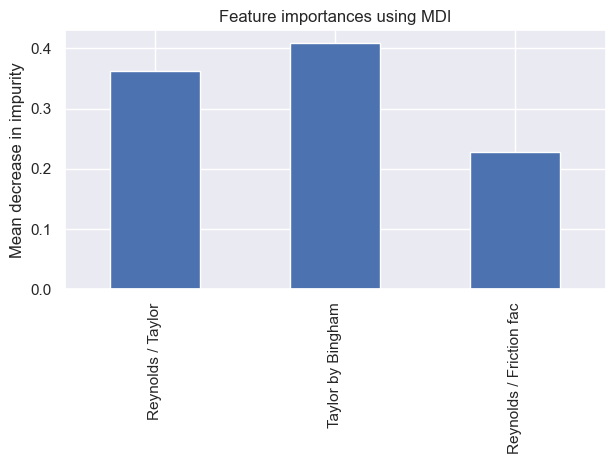

In [22]:
name_features = df.drop(columns = "Slip ratio").columns
importances = best_model_rf.feature_importances_

forest_importances = pd.Series(importances, index = name_features)
fig, ax = plt.subplots()
forest_importances.plot.bar()
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [23]:
def print_every_fold_validation(data_k_fold):
    metrics = []
    for idx in range(1,6):
        val_confmat = data_k_fold[f"Fold {idx}"]["Val confmat"]
        acc = (val_confmat[0,0] + val_confmat[1,1]) / np.sum(val_confmat)
        metrics.append(acc)
    for idx, accuracy in enumerate(metrics):
        print('Accuracy for fold: ',idx +1, '  ', accuracy)
    print(f'Average accuracy: {np.mean(metrics)} and std {np.std(metrics)}')

In [24]:
print_every_fold_validation(data_k_fold_nn)

Accuracy for fold:  1    0.7058823529411765
Accuracy for fold:  2    0.8823529411764706
Accuracy for fold:  3    0.8125
Accuracy for fold:  4    0.75
Accuracy for fold:  5    0.6875
Average accuracy: 0.7676470588235295 and std 0.07172039374468556
